In [78]:
import os
import torch
import itertools
from transformer import Transformer

N=20
dropout = .5
h=1
dim=120
l=1
f=128
ln_eps=1e-5
ln=False
iter=69000
i=1
deg=5
width=20
folderName = "."
dir_name = os.path.join(folderName,"HYPERPARAM_TESTS2")
seedNum = int(str(i)+str(deg)+str(width))
device = "cuda:0"
rank=0

def rboolf(N, width, deg,seed=None):
    if seed:
        torch.manual_seed(seed)
    coefficients = torch.randn(width).to(device)
    #print("coefficients initial shape: " + str(coefficients.shape) + ", width: " + str(width))
    coefficients = (coefficients-coefficients.mean())/coefficients.pow(2).sum().sqrt()
    
    combs = torch.tensor(list(itertools.combinations(torch.arange(N), deg))).to(device)
    combs = combs[torch.randperm(len(combs))][:width] # Shuffled
    return (coefficients, combs)


(coefs, combs) = rboolf(N, width, deg,seed=seedNum)
model = Transformer(dropout,N, dim, h, l, f, ln_eps,rank,ln)
# Load the state dictionary from a file
#try:
print("trying to load " + str(dir_name+"/model_"+str(iter)+".pt"))
state_dict = torch.load(dir_name+"/model_"+str(iter)+".pt")
model.load_state_dict(state_dict)
model.eval()


trying to load ./HYPERPARAM_TESTS2/model_69000.pt


Transformer(
  (embeddings): Embedding(2, 60)
  (transformer): Sequential(
    (0): AttentionBlock(
      (attn): CustomMHA(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=80, out_features=80, bias=False)
      )
      (linear): Sequential(
        (0): Linear(in_features=80, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=80, bias=True)
      )
    )
  )
)

In [79]:
import time 
import copy
import random
from pyhessian.hessian import hessian
import numpy as np

def makeBitTensor(x, N):
    y = format(x, "b")
    y = ("0"*(N-len(y))) + y
    return [int(z) for z in list(y)]
    
def get_weight_norm(model):
       total_norm = 0.0
       for p in model.parameters():
           if p.requires_grad:
               param_norm = p.data.norm(2)
               total_norm += param_norm.item() ** 2
       return total_norm ** 0.5
    
def calc_hessian(model, loss_fn, num_samples):
        model.eval().to(device)
        inputs = torch.tensor([random.randint(0, 2**N-1) for _ in range(num_samples)]).to(device)
        targets = func_batch(inputs).to(device)
        data = (inputs, targets)        

        # Estimate using PyHessian -- very good
        hess_mod = hessian(model, loss_fn, data, device=0)
        for param in model.parameters():
            param.grad = None
        top_eigs, top_eigVs = hess_mod.eigenvalues(maxIter = 200)
        print("top eigs: " + str(top_eigs))
        top_eig = top_eigs[0] 
        
        trace = hess_mod.trace()
        return top_eig, np.mean(trace)
    
def func_batch(x):
    binaryTensor = ((torch.tensor([makeBitTensor(y,N) for y in x])-.5)*2)
    comps = []
    #print("self.combs length: " + str(len(self.combs)))
    for elem in combs:
        res = torch.tensor([1]*len(x))
        for e in elem:
            bitCol = binaryTensor[:,e]
            res = torch.mul(res, bitCol)
        comps.append(res)
    comps = torch.transpose(torch.stack(comps),1,0).to(device)
    return torch.matmul(comps, coefs).to(device)


loss_fn = lambda result, targets: (result-targets).pow(2).mean()
    
start_time_hessian = time.time()

top_eig, trace = calc_hessian(copy.deepcopy(model), loss_fn=loss_fn, num_samples= 1000)
print("top eig Hessian: " + str(top_eig)+", trace Hessian: " + str(trace))
weight_norm = 0
weight_norm = get_weight_norm(model)
print("weight norm: " + str(weight_norm))
#weight_norm = torch.linalg.norm(self.model.weight)
top_eig=0
trace = 0
end_time_hessian = time.time()
elapsed_time_hessian = round((end_time_hessian - start_time_hessian)/60,3) 

top eigs: [13424.126953125]
top eig Hessian: 13424.126953125, trace Hessian: 65365.505208333336
weight norm: 52.92743861144146


bins: [ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7
  2.8  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1
  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5
  5.6  5.7  5.8  5.9  6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9
  7.   7.1  7.2  7.3  7.4  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3
  8.4  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7
  9.8  9.9 10. ]
val loss: None


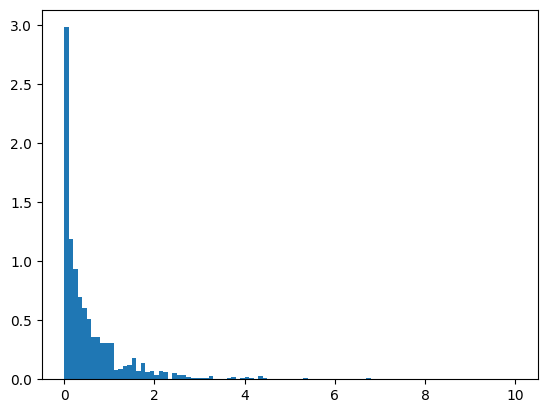

In [80]:
import matplotlib.pyplot as plt

def validate( num_samples): 
    model.eval()
    model.to(device)
    inputs = torch.tensor([random.randint(0, 2**N-1) for _ in range(num_samples)]).to(device)
    targets = func_batch(inputs).to(device)
    result = model(inputs).to(device)
    losses = (result - targets).pow(2).detach().cpu()
    max_bin=10
    n_bins=100
    bins = max_bin*np.array(range(n_bins+1),dtype="float")/n_bins
    print("bins: " + str(bins))
    hist =  np.histogram(losses, bins, density=True)
    plt.hist(losses,bins, density=True)
    loss = losses.mean()
    return 
    
val_loss = validate(1000) 
print("val loss: " + str(val_loss))